In [147]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd

from models.aa_common.data_loader import get_merged_scores_raw_df
from utils.data_dicts import methods_smaller_means_damaging_from_paper
from utils.performance_metrics import get_auc_roc_score

In [148]:
# PMD prediction scores distribution plot
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    # sns.histplot(result_df, x="pred", y="class", element="step", hue="class", bins=bins, alpha=0.2)
    
    plt.legend()
    plt.xlabel("Prediction scores")
    plt.ylabel("Count")
    plt.show()

In [149]:
method_names = ['sift', 'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw', 'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate', 'bStatistic', 
                'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S', 'esm2_t33_650M_UR50D', 
                'prottrans_bert_bfd', 'prottrans_albert_bfd', 'plus_rnn', 'prottrans_t5_xl_u50', 
                'vespa', 'vespal', 
                'proteinbert', 'sequnet', 'protbert', 'unirep']

task = "pmd"
df = get_merged_scores_raw_df(task, home_dir)

Index(['mut_id', 'md5', 'pmd_id', 'nr', 'prot_acc_version', 'snp_id',
       'mut_real', 'wt_aa_1letter', 'mt_aa_1letter', '1indexed_prot_mt_pos',
       'chrom_num', 'chrom_pos', 'ref_allele', 'alt_allele', 'function',
       'source', 'crossref', 'function_summarized', 'class', 'sift',
       'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw',
       'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate',
       'bStatistic', 'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S',
       'esm2_t33_650M_UR50D', 'prottrans_bert_bfd', 'prottrans_albert_bfd',
       'plus_rnn', 'prottrans_t5_xl_u50', 'vespa', 'vespal', 'proteinbert',
       'sequnet', 'protbert', 'unirep'],
      dtype='object')
(7179, 42)
Effect       3818
No-effect    1777
Knock-out    1584
Name: class, dtype: int64


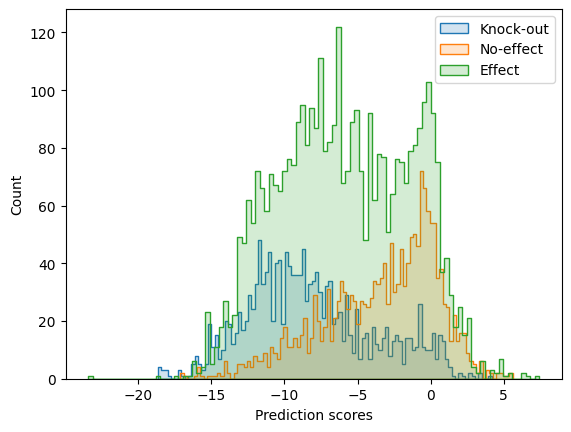

In [150]:
# watching raw scores
model_pred_col="esm1b_t33_650M_UR50S"
df["pred"] = df[model_pred_col]
plot_distribution(df)

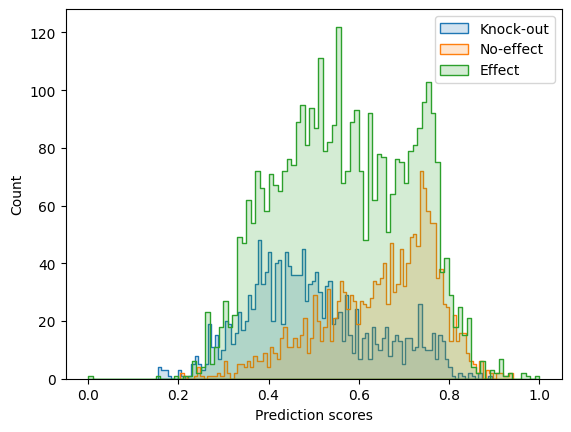

In [151]:
# watching [0, 1] scalled scores
df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]
plot_distribution(df)

In [152]:
# Effect, Knock-out
positive_cls, negative_cls = "Effect", "No-effect"

raw_direction_dict = {}
for i, method_name in enumerate(method_names):
    # print(i, method_name, end=" ")
    # method_name = "vespa"
    raw_direction = "larger_means_damaging"
    raw_direction_dict[method_name] = raw_direction
    
    # median = df[method_name].median()
    # print(df[pd.isna(df[method_name])][method_name])
    # df.loc[pd.isna(df[method_name]), method_name] = median # filling with median in the missing prediction score location
    df["pred"]=(df[method_name]-df[method_name].min())/(df[method_name].max()-df[method_name].min()) # scaling prediction scores between [0, 1]

    positive_cls_df = df[df["class"]==positive_cls].copy()
    negative_cls_df = df[df["class"]==negative_cls].copy()
    positive_cls_df["class_numeric"] = 1
    negative_cls_df["class_numeric"] = 0

    pos_neg_cls_df = pd.concat([positive_cls_df, negative_cls_df])
    nonan_pos_neg_cls_df = pos_neg_cls_df[~pd.isna(pos_neg_cls_df[method_name])]

    if method_name in methods_smaller_means_damaging_from_paper:
        raw_direction_dict[method_name] = "smaller_means_damaging"
    
    else:
        _, larger_means_damaging = get_auc_roc_score(nonan_pos_neg_cls_df)
        if not larger_means_damaging:
            raw_direction_dict[method_name] = "smaller_means_damaging"

    # print(raw_direction)

    df.drop(columns=["pred"], inplace=True)
    # break
raw_direction_dict

{'sift': 'smaller_means_damaging',
 'polyphen2_HVAR': 'larger_means_damaging',
 'metarnn': 'larger_means_damaging',
 'revel': 'larger_means_damaging',
 'mvp': 'larger_means_damaging',
 'cadd_raw': 'larger_means_damaging',
 'integrated_fitCons': 'smaller_means_damaging',
 'phyloP17way_primate': 'larger_means_damaging',
 'phastCons17way_primate': 'larger_means_damaging',
 'bStatistic': 'smaller_means_damaging',
 'esm1b_t33_650M_UR50S': 'smaller_means_damaging',
 'esm1v_t33_650M_UR90S': 'smaller_means_damaging',
 'esm2_t33_650M_UR50D': 'smaller_means_damaging',
 'prottrans_bert_bfd': 'smaller_means_damaging',
 'prottrans_albert_bfd': 'smaller_means_damaging',
 'plus_rnn': 'smaller_means_damaging',
 'prottrans_t5_xl_u50': 'smaller_means_damaging',
 'vespa': 'larger_means_damaging',
 'vespal': 'larger_means_damaging',
 'proteinbert': 'smaller_means_damaging',
 'sequnet': 'larger_means_damaging',
 'protbert': 'smaller_means_damaging',
 'unirep': 'larger_means_damaging'}

In [169]:
direction_df = pd.DataFrame(list(raw_direction_dict.items()), columns=["method_name", "raw_direction"])
direction_df.to_csv(home_dir+f"data/merged_predictions_raw/raw_scores_direction.tsv", sep="\t", index=False, header=True)

### change direction now

In [156]:
def change_direction(df:pd.DataFrame):
    for i, method_name in enumerate(method_names):
        print(i, method_name)
        # method_name = "esm1b_t33_650M_UR50S"

        # median = df[method_name].median()
        # df.loc[pd.isna(df[method_name]), method_name] = median # filling with median in the missing prediction score location
        df["pred"]=(df[method_name]-df[method_name].min())/(df[method_name].max()-df[method_name].min()) # scaling prediction scores between [0, 1]

        if raw_direction_dict[method_name] == "smaller_means_damaging":
            df[method_name] = 1 - df['pred'].copy() # changing the direction
        else: 
            df[method_name] = df['pred'].copy()

        df.drop(columns=["pred"], inplace=True)
        # break
    return df

In [163]:
task = "pmd" # pmd, popu_freq, patho
df = get_merged_scores_raw_df(task, home_dir)
df = change_direction(df)
df.to_csv(home_dir+f"data/merged_predictions_unidirectional/{task}.tsv", sep="\t", index=False, header=True)

Index(['mut_id', 'md5', 'pmd_id', 'nr', 'prot_acc_version', 'snp_id',
       'mut_real', 'wt_aa_1letter', 'mt_aa_1letter', '1indexed_prot_mt_pos',
       'chrom_num', 'chrom_pos', 'ref_allele', 'alt_allele', 'function',
       'source', 'crossref', 'function_summarized', 'class', 'sift',
       'polyphen2_HVAR', 'metarnn', 'revel', 'mvp', 'cadd_raw',
       'integrated_fitCons', 'phyloP17way_primate', 'phastCons17way_primate',
       'bStatistic', 'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S',
       'esm2_t33_650M_UR50D', 'prottrans_bert_bfd', 'prottrans_albert_bfd',
       'plus_rnn', 'prottrans_t5_xl_u50', 'vespa', 'vespal', 'proteinbert',
       'sequnet', 'protbert', 'unirep'],
      dtype='object')
(7179, 42)
Effect       3818
No-effect    1777
Knock-out    1584
Name: class, dtype: int64
0 sift
1 polyphen2_HVAR
2 metarnn
3 revel
4 mvp
5 cadd_raw
6 integrated_fitCons
7 phyloP17way_primate
8 phastCons17way_primate
9 bStatistic
10 esm1b_t33_650M_UR50S
11 esm1v_t33_650M_UR90S
12 esm

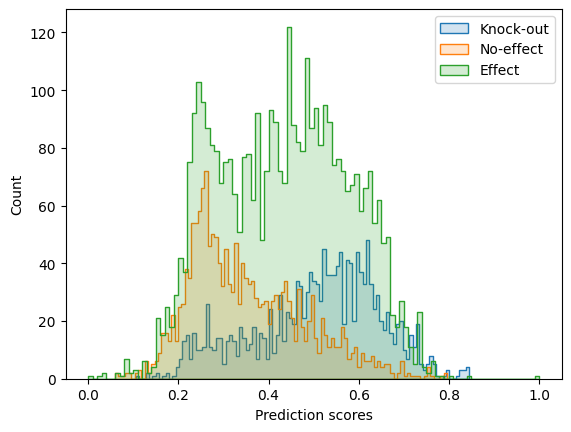

(0, 43)


In [160]:
# watching direction-changed scores, this only plots for pmd
method_name = "esm1b_t33_650M_UR50S"
df["pred"] = df[method_name]
plot_distribution(df)
# did it change: yes
print(df[pd.isna(df[method_name])].shape)